In [15]:
# NEW CODE

#Packages

import os
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
from copy import deepcopy

from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals

In [16]:
# Function to call Praful's code, returning an Excel file with the cores identified

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

In [17]:
#Function to find the cores and print them, it takes "data" (the Excel file) as input. The function used to rearrange the cores into Metzler matrices to check their positive unstability, in the previous version

def stoichio(data, SM, N_Y, N_RY):
    
    matrices = [] # List of cores that will be found

    SM = np.array(SM)
    
    for index, riga in data.iloc[1:].iterrows(): # Spanning among the rows of the Excel file (the rows are the autocatalytic cores)
        indices_N_Y = [i for i, valore in enumerate(riga[(2 + N_Y):(2 + 2*N_Y)]) if valore == 1]   # Save the species that belong to the core
        indices_N_RY = [i for i, valore in enumerate(riga[(2 + 2*N_Y):(2 + 2*N_Y + N_RY)]) if valore == 1]   # Save the reactions that belong to the core
        
        submatrix = SM[np.ix_(indices_N_Y, indices_N_RY)]

        matrices.append(submatrix) # Append all the cores together

    return len(matrices)

In [18]:
# NOT USEFUL IN THIS VERSION OF THE CODE

def calculate_jacobian_and_eigenvalues(S1, S, kf, kr, N_Y, reverse, law):
    # Defining the species symbols
    species_sym = symbols(f'Y0:{N_Y}')
    
    # Convert S and S1 to integer types to avoid floating-point issues
    S = S.astype(int)
    S1 = S1.astype(int)

    # Constructing the symbolic expressions for the rates
    ratef_sym = np.array([kf[i] for i in range(len(kf))], dtype=object)  # Ensure symbolic compatibility
    rater_sym = np.array([kr[i] for i in range(len(kr))], dtype=object)

    # Now for each reaction, compute the rate based on the law (MAL or MM)
    if law == "MAL":
        for l in range(len(ratef_sym)):
            for s, p in zip(species_sym, S[:, l]):
                ratef_sym[l] *= s**p  # p is now an integer
            for s, p in zip(species_sym, S1[:, l]):
                rater_sym[l] *= s**p

    # Compute the net current (curr_forward - curr_backward)
    current_sym = ratef_sym - rater_sym
    
    # Create the Jacobian matrix as the derivative of (S1 - S) @ current_sym w.r.t. species
    jacobian = Matrix((S1 - S)) * Matrix(current_sym)
    jacobian = jacobian.jacobian(species_sym)
    print(jacobian)
    
    # Substitute all species concentrations to zero (since you want to evaluate at zero concentration)
    jacobian_zero = jacobian.subs({species_sym[i]: 0 for i in range(len(species_sym))})
    
    # Convert the symbolic Jacobian into a numeric matrix
    jacobian_numeric = np.array(jacobian_zero).astype(np.float64)

    # Compute the eigenvalues of the numeric Jacobian
    eigenvalues = eigvals(jacobian_numeric)
    
    # Return the maximum real part of the eigenvalues
    max_real_eigenvalue = max(eigenvalues.real)
    
    return max_real_eigenvalue, jacobian_numeric, eigenvalues


In [19]:
# Function that calls Praful's code, gives back (print) the cores and the autocatalytic behavior of the network

def autocat_detection(Stot, N_X, N_RX, resSp):
    
    auto(Stot, N_X) # Calling Praful's program on the matrix
    data = pd.read_excel("output/AC_n%d.xlsx"%(N_X), header = None) 

    if  len(data.iloc[:][0]) > 1:    # Checking the existance of AT LEAST a core in the matrix from the excel output file

        print("INVADERS SHOW AUTOCATALYSIS \n \n")

        cores = stoichio(data, Stot, N_X, N_RX) # This will print (not in the file) every core found!

        resSp.write('The network shows autocatalysis \n \n')

        #autocatalytics.append(True)

    else:

        print("NO AUTOCATALYTIC BEHAVIOR \n \n")

        resSp.write('The network does not show autocatalysis \n \n')

        cores = 0

        #autocatalytics.append(False)

    return cores


In [20]:
def invaders_matrices(N_RY, N_RX, N_X, S_Y, S1_Y, S_X, S1_X, resSp, invaders_autocatalysis):

    # Construction of the random network of the invaders

    for i in range(N_RY):
                
        total_order_for = random.randint(0, 2)  # Total order for the forward
        total_order_bac = random.randint(0, 2)  # Total order for the backward
        stoichio_for = 0
        stoichio_bac = 0

        # Setting the necessary reactants without ambiguity
        
        species1 = random.randint(0, N_Y - 1) # There must be at least one Y as reactant
        S_Y[N_X + species1][i] += 1
        

        # Setting the necessary products without ambiguity
            
        species2 = random.randint(0, N_Y - 1)
            
        while species2 == species1:
            species2 = random.randint(0, N_Y - 1) # Non-ambiguity condition
        S1_Y[N_X + species2][i] += 1    # There must be at least one Y as product'''
            
        # CASE 1: we allowed autocatalysis for invaders on their own (COMPETITION)
        
        if invaders_autocatalysis:
            
            while(stoichio_for < total_order_for - 1): # Costructing the stoichio forward matrix randomly, up to a total order

                species = random.randint(0, N_X + N_Y - 1) # REACTANTS CAN BE EITHER X's or Y's

                if S1_Y[species][i] == 0:  # Non ambiguity
                    S_Y[species][i] += 1
                    stoichio_for += 1



    
            while(stoichio_bac < (total_order_bac - 1)): # Costructing the stoichio backward matrix randomly, up to a total order
    
                species = random.randint(0, N_Y - 1)  # NO X's AS PRODUCTS

                if S_Y[N_X + species][i] == 0:  # Non ambiguity
                    S1_Y[N_X + species][i] += 1
                    stoichio_bac += 1

        # CASE 2: we didn't allow autocatalysis for invaders on their own (PARASITES)
        
        elif not invaders_autocatalysis:
            
            while(stoichio_for < total_order_for - 1): # Costructing the stoichio forward matrix randomly, up to a total order
    
                species1 = random.randint(0, N_X - 1) # REACTANTS CAN ONLY BE X's, SO NO AUTOCAT FOR Y's
    
                if S1_Y[species1][i] == 0:  # Non ambiguity
                    S_Y[species1][i] += 1
                    stoichio_for += 1
    
    
    
    
            while(stoichio_bac < (total_order_bac - 1)): # Costructing the stoichio backward matrix randomly, up to a total order
    
                if total_order_for == 2 and species1 < N_X: # CONDITON THAT ALLOWS TO PICK Y AS PRODUCTS ONLY IF THERE IS ONE X AS A REACTANT!
                    species2 = random.randint(0, N_X + N_Y - 1) 
        
                    if S_Y[species2][i] == 0:  # Non ambiguity
                        S1_Y[species2][i] += 1
                        stoichio_bac += 1
                else:
                    species2 = random.randint(0, N_X - 1)  # IF IT'S NOT, THEN YOU CAN'T PICK A Y, OTHERWISE YOU'D HAVE AUTOCAT!
        
                    if S_Y[species2][i] == 0:  # Non ambiguity
                        S1_Y[species2][i] += 1
                        stoichio_bac += 1

        else: 
            raise ValueError("One must choose if the invaders present or not autocatalysis on their own")
            

    # TOTAL MATRIX OF THE INVADERS    
    S_Y_Tot = S1_Y - S_Y


    #CONSTRUCTION OF THE WHOLE MATRIX OF ORIGINAL AND INVADERS, STACKING TOGETHER THE X ONE AND THE NEW Y ONE JUST CONSTRUCTED
    
    zeros_below_S_X = np.zeros((N_Y, N_RX))

    upper_block = np.hstack((S_X, S_Y[:N_X]))
    
    lower_block = np.hstack((zeros_below_S_X, S_Y[N_X:])) 
    
    S_XandY_forward = np.vstack((upper_block, lower_block))

    upper_block = np.hstack((S1_X, S1_Y[:N_X]))
    
    lower_block = np.hstack((zeros_below_S_X, S1_Y[N_X:])) 

    S_XandY_backward = np.vstack((upper_block, lower_block))

    #NON-INVERTED WHOLE MATRIX
    S_XandY = S_XandY_backward - S_XandY_forward # THIS IS MATRIX (21) IN INVADERS NOTES
                

    # AUTOCATALYSIS CHECKING
    # Preparing the input for Praful's code splitting the reactions in backward and forward

    new_stot_col = []
    
    for stot_col in S_XandY.T:
        new_stot_col.extend([stot_col, -stot_col])
    
    #INVERTED WHOLE MATRIX (EACH COLUMN HAS THE OPPOSITE ONE NEXT TO IT, SO THAT REVERSIBLE REACTIONS ARE "SPLIT", THIS IS THE ONLY GOOD INPUT FOR PRAFUL'S CODE)
    S_XandY_REVERSED = np.column_stack(new_stot_col).astype(int)

    return S_XandY_backward, S_XandY_forward, S_XandY, S_XandY_REVERSED, S_Y_Tot

In [21]:
def Ydynamics(N_Y, N_RY, N_X, N_RX, Ntot, S1_X, S_X, S_XandY, S_XandY_forward, S_XandY_backward, X, Y, kf, kr, law, res_invasion, resY, temps, dt, TIME, initials_chemo):
    
    for i in range(npas//100): # Two timescales to print not too much
            
        temps = (i * 100) * dt
        
        print(f"{round(temps + TIME ,1)} {round(Ntot,3)} ", file=resY) # THE POPULATION FILE WILL HAVE THE TOTAL POPULATION SUM PRINTED
        
        for j in range(100):
            
            curr = np.zeros(N_RX + N_RY) # Vector of currents
            curr_for = np.zeros(N_RX + N_RY) # Vector of forward currs
            curr_bac = np.zeros(N_RX + N_RY) # Vector of backward currs

            
            # If I have MAL, I update the currents each iteration
            if law == "MAL":

                ratef = kf[:]
                rater = deepcopy(kr)
                
                for l in range(N_RX + N_RY):
                    
                    for s, p in zip(np.concatenate((X,Y)), S_XandY_forward[:,l]):  # Updating the currents for each reaction each time step
                        ratef[l] *= pow(s, p)
                    for s, p in zip(np.concatenate((X,Y)), S_XandY_backward[:,l]):  # Same but backward
                        rater[l] *= pow(s, p)   
                   
                    curr[l] = np.array(ratef[l]) - np.array(rater[l]) # Updating the currents

                    curr_for[l] = np.array(ratef[l])
                    curr_bac[l] = np.array(rater[l])
                    
                        

            # If I have MM, the forward rate will change, the backward will still be MAL
            if law == "MM":

                ratef = np.ones(len(kf[:]))
                rater = deepcopy(kr)

                for l in range(N_RX + N_RY):
                    
                    prod = 1
                    
                    for s, p in zip(np.concatenate((X,Y)), S_XandY_forward[:,l]):  # Updating the currents for each reaction each time step
                        prod *= pow(s, p)
                    ratef[l] = prod/(kf[l] + prod)
                   
                    for s, p in zip(np.concatenate((X,Y)), S_XandY_backward[:,l]):  # Same but backward
                        rater[l] *= pow(s, p)  

                    curr[l] = np.array(ratef[l]) - np.array(rater[l])    

                    curr_for[l] = np.array(ratef[l])
                    curr_bac[l] = np.array(rater[l])

            # ODE 
            Y += dt * np.dot((S_XandY)[N_X:][:], np.array(curr))   # Solving a timestep ODE for the vector of invaders
            Y[Y < 0] = 0 # Non-negativity condition

 
            X[initials_chemo:] += dt * np.dot((S_XandY)[initials_chemo:N_X][:], np.array(curr))   # Solving a timestep ODE for the vector of ORIGINALS, so X AFTER the foods (initials_chemo...)
            #A PART FROM THE FIRST initials_chemo WHICH WILL REMAIN CHEMOSTATED
            X = np.array(X)
            X[X < 0] = 0 # Non-negativity condition

            
            Xtot = sum(X) # Update the originals species
            Ytot = sum(Y) # Update the invaders species
            Ntot = Xtot + Ytot

        res_invasion.write(f"{round(TIME+temps, 1)}")
        for x in np.concatenate((X,Y)):
            res_invasion.write(f" {round(x, 3)}")  # Printing all the species on the fileof the current invasion
        res_invasion.write("\n")
            
    return X, Y, curr, curr_for, curr_bac, Xtot, Ytot, Ntot, res_invasion, resY

In [22]:
# Function to plot the currents as the forwards-backwards or as in the form of an histogram for the log-net ones

def plot_currents(curr_for = None, curr_bac = None, curr = None, plot_type = "forward_backward"):
    
    if plot_type == "forward_backward":            # This plots the first of the plots each invasion
        if curr_for is None or curr_bac is None:
            raise ValueError("curr_for & curr_bac needed for 'forward_backward'")
        
        # Labels and values
        num_elements = len(curr_for)
        labels = []
        values = []
        for i in range(num_elements):
            labels.append(f"$J_{{{i+1}}}^+$")  # Forward
            values.append(curr_for[i])
            labels.append(f"$J_{{{i+1}}}^-$")  # Backward
            values.append(curr_bac[i])
        
        # X axis
        x_positions = np.arange(len(values))
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(x_positions, values, color=['skyblue' if i % 2 == 0 else 'lightcoral' for i in range(len(values))])
        
        # Axes and titles
        ax.set_xticks(x_positions)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_ylabel('Current Values')
        ax.set_title('Forward and Backward Currents')
        
        # Grid
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    elif plot_type == "log_histogram":           # This plots the second of the plots each invasion
        if curr is None:
            raise ValueError("curr needed for 'log_histogram'")
        
        # Log calculation of the currents, the +1 is for positive currents that are <1 and would result in a negative log. The transformation is sign(j)*log(|j| + 1)  
        x_labels = [f'$J_{{{i+1}}}$' for i in range(len(curr))]
        log_curr = np.sign(curr) * np.log(np.abs(curr) + 1)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.bar(x_labels, log_curr, color='skyblue', edgecolor='black')
        
        # Axis and titles
        plt.xlabel('Currents (Log scale)')
        plt.ylabel('Values')
        plt.title('Histogram of Log-Currents')
        
        # Grid
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        raise ValueError("plot_type must be either 'forward_backward' or 'log_histogram'")

In [27]:
# Main function to check autocatalysis and run simulations  (THE newest VERSION)  with THERMODYNAMIC CONSTRAINT

def invasion_thermo(N_F, N_Y, N_RY, ttot, dt, Invasions, law, invaders_autocatalysis):

    currents = []
    affinities = []
    winning_currents = []
    winning_affinities = []
    number_of_cores = []
    
    # Number of steps
    npas = int(ttot / dt)
    
    N_X = N_F # At the beginning foods are the only present species that will not evolve

    #max_lambda = []
    
    # Inizialization of compt (number of succeding invasions)
    # Initialization of TIME (total time passed)
    # Initialization of r (current number of trial invasion)
    compt = 0
    temps = 0
    TIME = 0
    r=0
    
    #autocatalytics = []
    #survival = []

    
    # Delete the previous output
    [shutil.rmtree(os.path.join('output', f)) if os.path.isdir(os.path.join('output', f)) else os.unlink(os.path.join('output', f)) for f in os.listdir('output')]

    #Opening and setting up the Total Time file and the Stoiochiometric one
    
    resY = open("output/Population.dat", "w") # File containing the evolution of the WHOLE population (X+Y)
    resSp = open("output/Stoichiometry.dat", "w") # File containing the history of all the stoichiometric invasions and trials

    resY.truncate(0) # Deleting everything in the files
    resSp.truncate(0)

    
    # Numbers of chemostats fixed at the beginning
    initials_chemo = N_F
    
    X = [ 3 for _ in range(N_X)] # Initialize original species (for now the food)
    X = np.array(X, dtype=np.float64)
    
    mu_0 = [random.uniform(-1, 1) for _ in range(N_X)] # For the thermodynamical feasibility of the reactions (giving a CHEMISTRY to food)

    Ntot = sum(X) # Total concentrations that will be updated after every invasion
    Xtot = Ntot # Initial number of original species (food in this case)

    res_invasion = open(f"output/time_{0}.dat", "w") # Opening the file for the evolution of the original species before any invasion
    

    # I WILL LET THE FOOD TO "EVOLVE" CONSTANTLY TILL THE FIRST INVASION

    for i in range(npas//100): # Two timescales to print not too much
            
        temps = (i * 100) * dt
        
        res_invasion.write(f"{round(TIME + temps, 1)}")
        for x in X:
            res_invasion.write(f" {round(x, 3)}")
        res_invasion.write("\n")

        print(f"{round(temps + TIME ,1)} {round(Ntot,3)} ", file=resY)
    

        
    TIME += ttot

    

    # SET OF INVASIONS

    counter = True     # This serves to the code to understand whether or not an invasion will win, at the beginning is set on TRUE because we have to propose new species and rates 
                       # Later it will be set to FALSE if an invasion didn't succeed, so the code WILL NOT produce more rates and species, till one invasion succeed and it will be set to TRUE
    

    # We don't have reactions at the beginning
    kf = []
    kr = []

    # This matrix will be the one of the original species, but now we don't have any reactions but we have some food N_X = N_F. This is matrix S is S_X in the notes Invaders, but we use only the forward and backward
    S_X = np.empty((N_X, 0))
    S1_X = np.empty((N_X, 0))
    S = S1_X - S_X

    
    # Initial number of original reactions
    N_RX = 0

    
    # Invasions start
    for r in range(Invasions):

        resSp.write('INVASION NUMBER %d \n \n' %(r+1))
    
        S_Y = np.zeros((N_X + N_Y, N_RY)) # Stoichiometric matrix of the invaders' reactions and for all the species (forward processes)
        S1_Y = np.zeros((N_X + N_Y, N_RY)) # Stoichiometric matrix of the invaders' reactions and for all the species (reverse processes)

        '''S_Y = np.array([
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [1, 0, 1, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1]
                        ])

        S1_Y = np.array([
            [0, 0, 1, 0],
            [0, 0, 0, 1],
            [0, 2, 0, 1],
            [1, 0, 0, 1],
            [0, 0, 1, 0]
                        ])'''

        # S is the forward matrix (S+) and S1 is the reverse one (S-)

        res_invasion = open(f"output/time_{r+1}.dat", "w") # File for the invasions' printings
        
        
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)] # Initialize values for the new invaders' species
        Ytot = Y

        if counter: # I will add new rates and new mu_0's only if invasion worked and I have to add new MORE species
            new_kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)] # Initialize constant values for the forward rates
            new_mu0 = [random.uniform(-1, 1) for _ in range(N_Y)] # For the thermodynamical feasibility of the reactions

            kf.extend(new_kf) # Adding constants and mu_0 to the ones before
            mu_0.extend(new_mu0)

        
        # Calling the function that produces the whole S_XY, the backward, the forward and the ones only for the invaders
        S_XandY_backward, S_XandY_forward, S_XandY, S_XandY_REVERSED, S_Y_Tot = invaders_matrices(N_RY, N_RX, N_X, S_Y, S1_Y, S_X, S1_X, resSp, invaders_autocatalysis)    

          
        #Thermodynamical constraint
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S_XandY.T, mu_0_vector).flatten()
    
        kf_reversible = np.array(kf)
        kr_reversible = kf_reversible * np.exp(DeltaG0)  
        kr = kr_reversible
        
        # Calling the function that calls Praful's program on the REVERSED matrix, removing the food species
        cores = autocat_detection(S_XandY_REVERSED[initials_chemo:, :], N_X + N_Y- initials_chemo, N_RX + N_RY, resSp)

        number_of_cores.append(cores)

         # Calling the function that simulates dynamics, estimate the steady state currents and updates X and Y species
        X, Y, curr, curr_for, curr_bac, Xtot, Ytot, Ntot, res_invasion, resY = Ydynamics(N_Y, N_RY, N_X, N_RX, Ntot, S1_X, S_X, S_XandY, S_XandY_forward, S_XandY_backward, X, Y, kf, kr, law, res_invasion, resY, temps, dt, TIME, initials_chemo)

        aff = np.zeros(N_RX + N_RY)
        for l in range(N_RX + N_RY):
            aff[l] = np.log(curr_for[l]/curr_bac[l])
            
        # Closing the file of the current invasion
        res_invasion.close()

        
        # HISTOGRAM OF THE CURRENTS AT STEADY STATE, FOR EACH INVASION

        # Plot forward e backward currents
        plot_currents(curr_for=curr_for, curr_bac=curr_bac, plot_type="forward_backward")
        
        # Plot log-scale histogram
        plot_currents(curr=curr, plot_type="log_histogram")

               
        resSp.write('Invaders matrix \n')
        np.savetxt(resSp, S_Y_Tot, fmt='%d', delimiter=' ', header='', comments='')     # Printing the INVADERS matrix in "Stoichiometry"
        resSp.write('\nWhole matrix after invasion \n')

        np.savetxt(resSp, S_XandY, fmt='%d', delimiter=' ', header='', comments='') # Printing the WHOLE matrix in "Stoichiometry"

        # Time increasing after the invasion trial
        TIME += ttot

        # Appending all the new currents for the trial systems, to make the pdf. Can be made also with log-currents or can be put into if Ytot: to make it only for surviving
        currents.extend(curr)
        affinities.extend(aff)
        
        # Did the invaders survive?
        if Ytot >= 0.2: # Threshold for survival
            compt += 1
            
            resSp.write("\n")
            resSp.write('Invaders grew and mixed with the community')
            resSp.write("\n \n")

            # INVADERS BECOME ORIGINAL SPECIES IF THEY SURVIVED
            N_X += N_Y
            N_RX += N_RY
    
            S1_X = S_XandY_backward
            S_X = S_XandY_forward
    
            X = np.concatenate((X,Y))
            Xtot += Ytot
            counter = True
            #survival.append(True)
            
    
        else: 
            resSp.write("\n")
            resSp.write("Invaders died and their matrix is discarded")
            resSp.write("\n \n")
    
            #survival.append(False)
            counter = False

    winning_currents.extend(curr)
    winning_affinities.extend(aff)

    
     # Saving and closing the open files
    
    print(f"{compt}/{Invasions} Realizations led to successful invasion")
    resSp.close()
    resY.close() 

    return currents, affinities, winning_currents, winning_affinities, number_of_cores

In [28]:
#Parameters definition

ttot = float(100.0) # Total time for the each invasion
dt = 1.0E-3 # Timestep

npas = int(ttot//dt)

Invasions = 10 # Number of invasions

N_F = 20 # Number of species acting as food

N_Y = 3  # Number of invaders (must be higher than 3, otherwise I can end up with ambiguity) added every ttot
N_RY = 3  # Number of reactions for the invaders added every ttot

#Species:  3 # Reactions:  6
#Species:  3 # Reactions:  6
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_3 ->C+C_2
			 R6: C_2 ->2C_3
	 - CPU Time: 0.00 secs


# Autocatalytic Cycles: 1
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
INVADERS SHOW AUTOCATALYSIS 
 



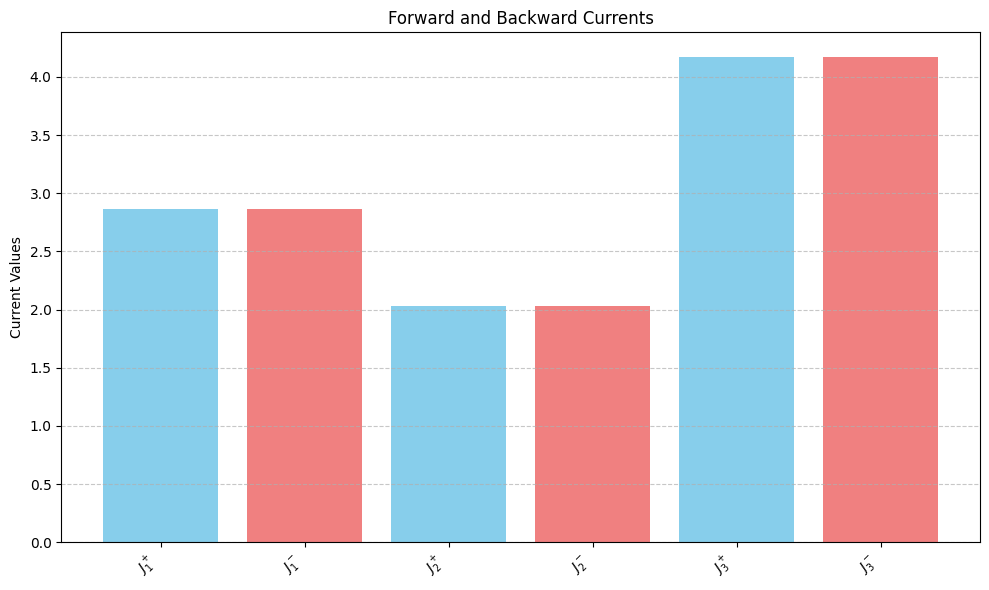

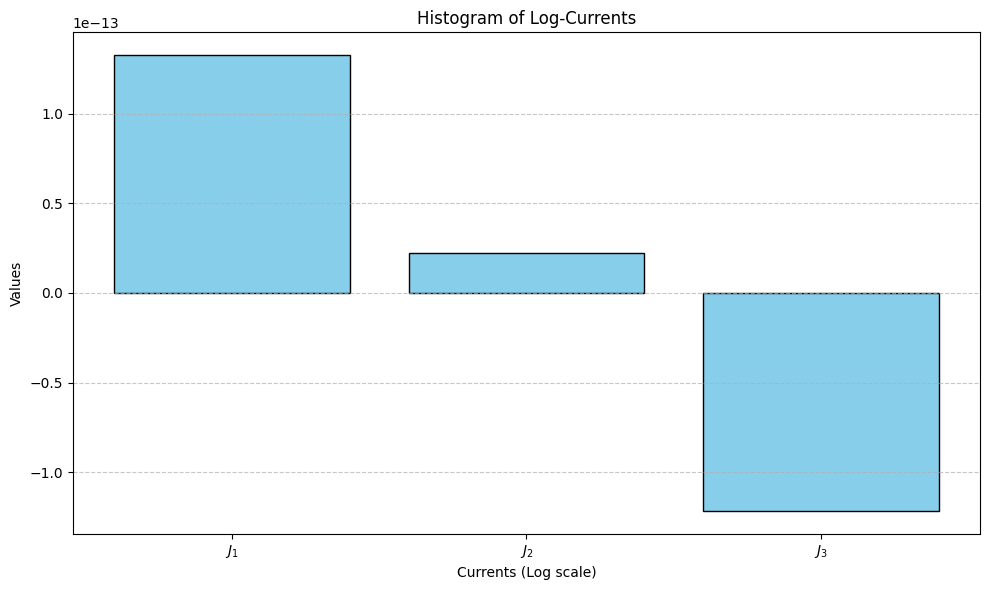

#Species:  6 # Reactions:  12
#Species:  6 # Reactions:  12
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_3 ->C+C_2
			 R6: C_2 ->2C_3
	 - CPU Time: 0.07 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R7', 'R9', 'R11']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R7: C_4 ->C_6
			 R9: C_5 ->C_6
			 R11: C_6 ->C_4+C_5
	 - CPU Time: 0.01 secs


# Autocatalytic Cycles: 2
Consumed Time: 0.07 secs.
Saved in output/AC_n6.xlsx
INVADERS SHOW AUTOCATALYSIS 
 



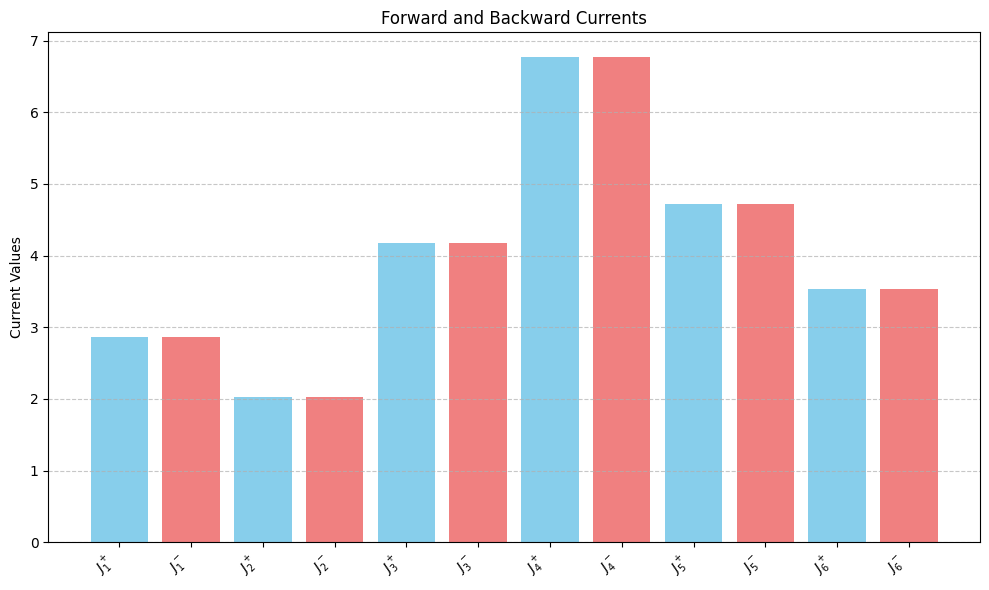

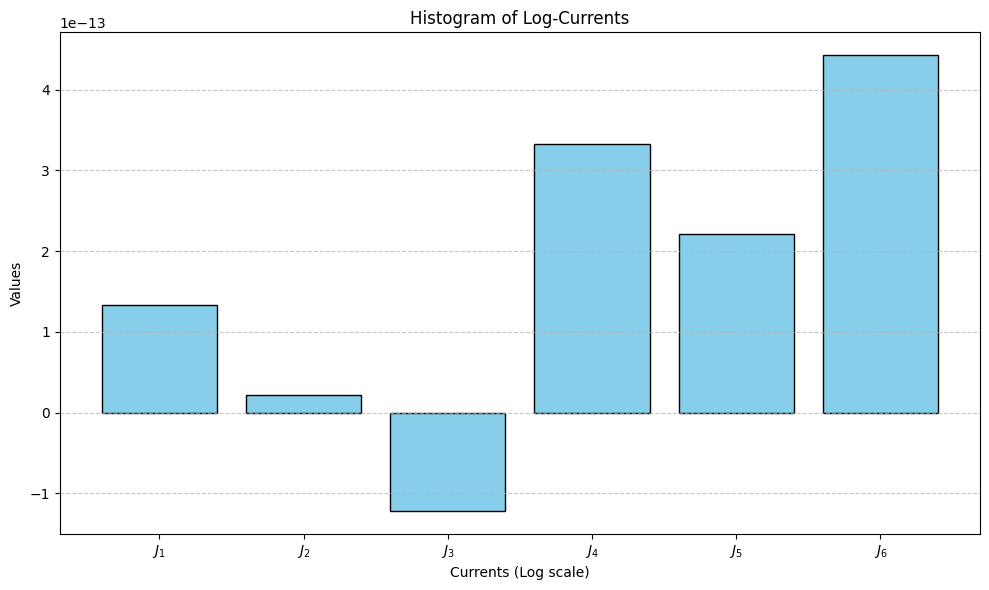

#Species:  9 # Reactions:  18
#Species:  9 # Reactions:  18
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_3 ->C+C_2
			 R6: C_2 ->2C_3
	 - CPU Time: 0.00 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R7', 'R9', 'R11']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R7: C_4 ->C_6
			 R9: C_5 ->C_6
			 R11: C_6 ->C_4+C_5
	 - CPU Time: 0.00 secs


# Autocatalytic Cycles: 2
Consumed Time: 0.01 secs.
Saved in output/AC_n9.xlsx
INVADERS SHOW AUTOCATALYSIS 
 



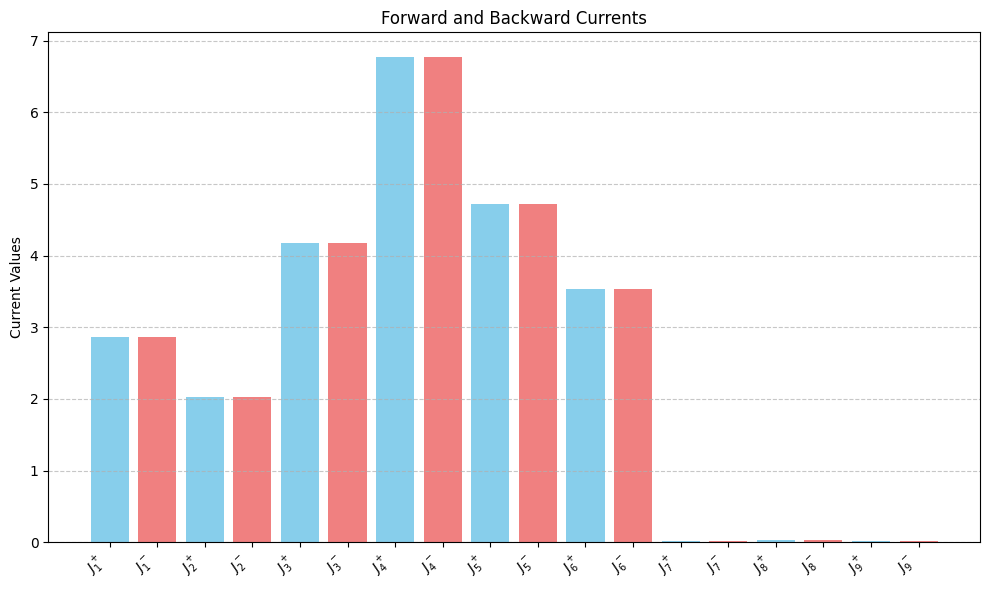

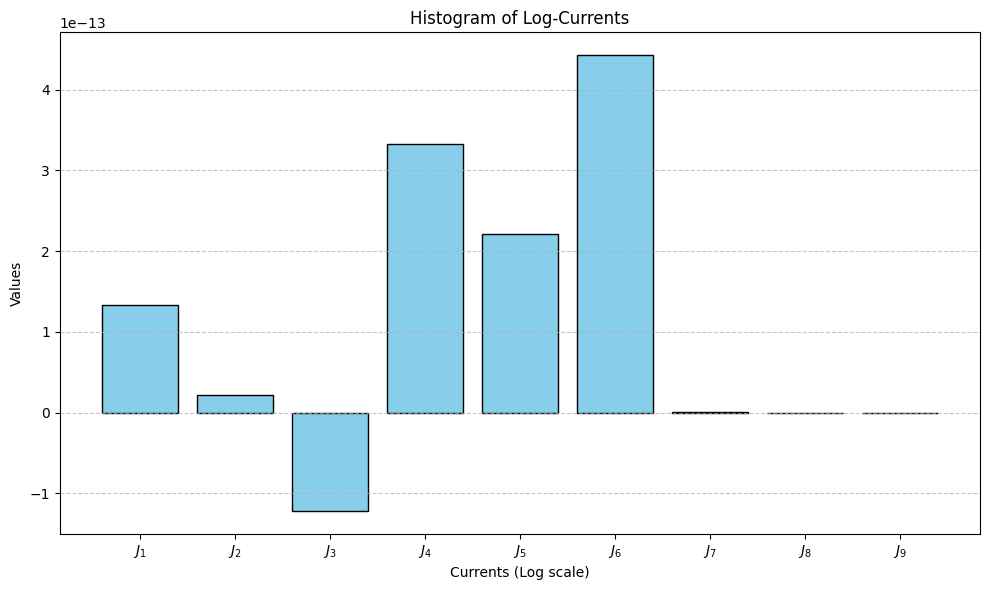

#Species:  9 # Reactions:  18
#Species:  9 # Reactions:  18
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_3 ->C+C_2
			 R6: C_2 ->2C_3
	 - CPU Time: 0.00 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R7', 'R9', 'R11']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R7: C_4 ->C_6
			 R9: C_5 ->C_6
			 R11: C_6 ->C_4+C_5
	 - CPU Time: 0.00 secs
**** Sol 3: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_7', 'C_8', 'C_9']
	 Reactions in AC:  ['R13', '

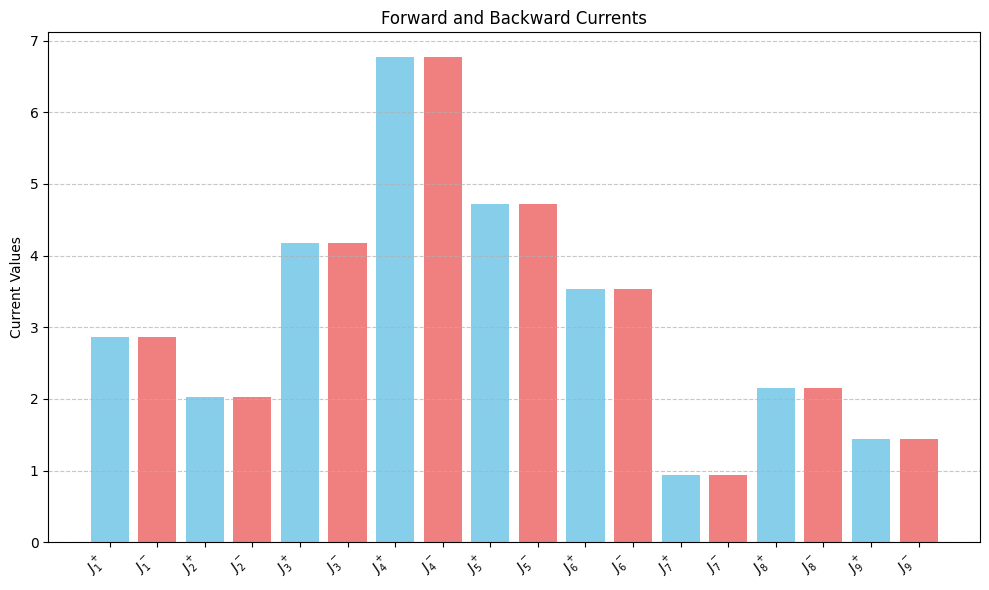

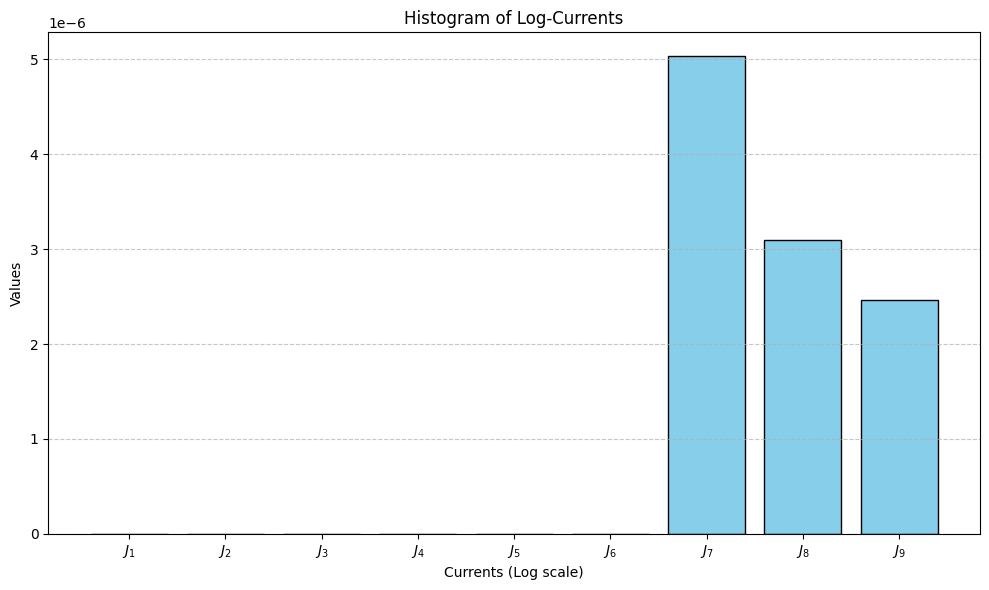

#Species:  12 # Reactions:  24
#Species:  12 # Reactions:  24
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_3 ->C+C_2
			 R6: C_2 ->2C_3
	 - CPU Time: 0.00 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R7', 'R9', 'R11']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R7: C_4 ->C_6
			 R9: C_5 ->C_6
			 R11: C_6 ->C_4+C_5
	 - CPU Time: 0.00 secs
**** Sol 3: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_7', 'C_8', 'C_9']
	 Reactions in AC:  ['R13',

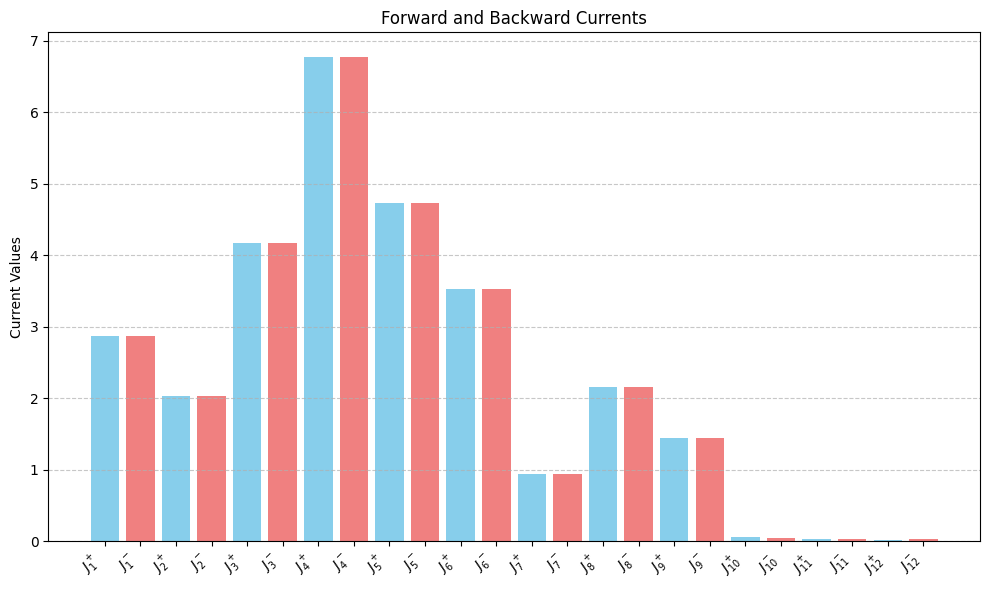

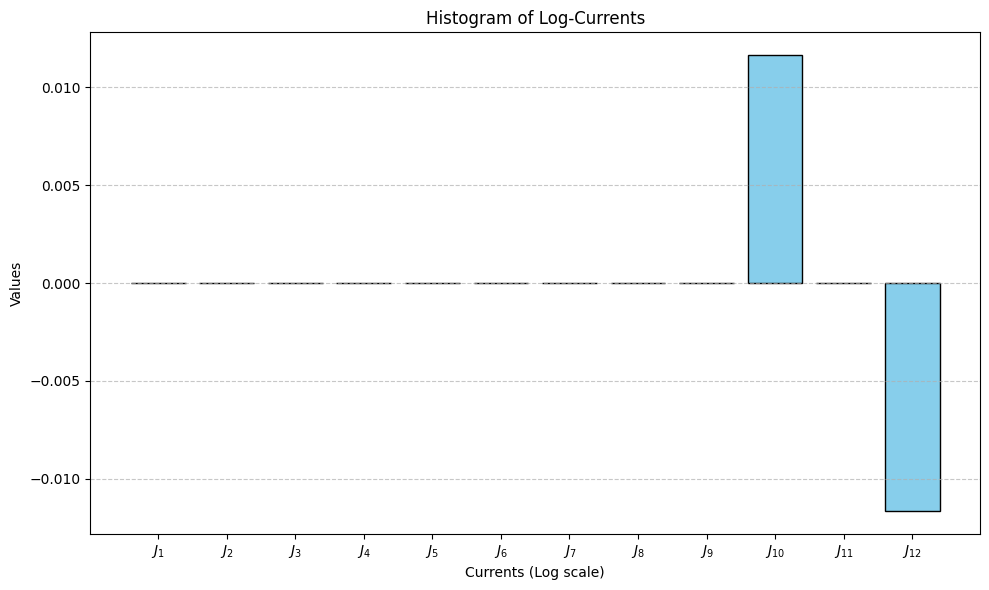

#Species:  12 # Reactions:  24
#Species:  12 # Reactions:  24
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_3 ->C+C_2
			 R6: C_2 ->2C_3
	 - CPU Time: 0.07 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R7', 'R9', 'R11']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R7: C_4 ->C_6
			 R9: C_5 ->C_6
			 R11: C_6 ->C_4+C_5
	 - CPU Time: 0.01 secs
**** Sol 3: 3 reactions
	 #Species:  3 #FoodSet:  1 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C_7']
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_10', 'C_11', 'C_12']
	 Reactions in AC: 

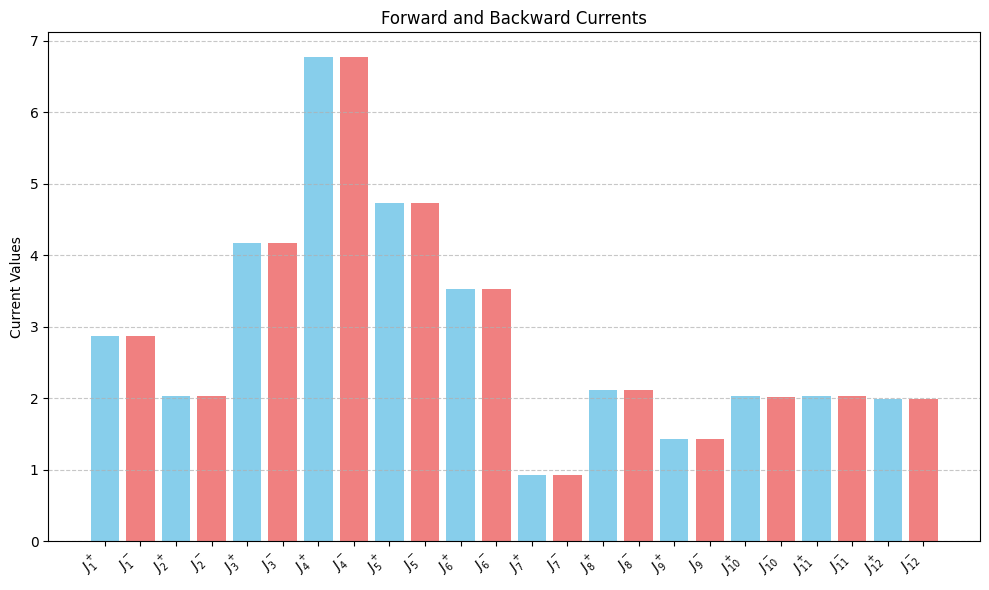

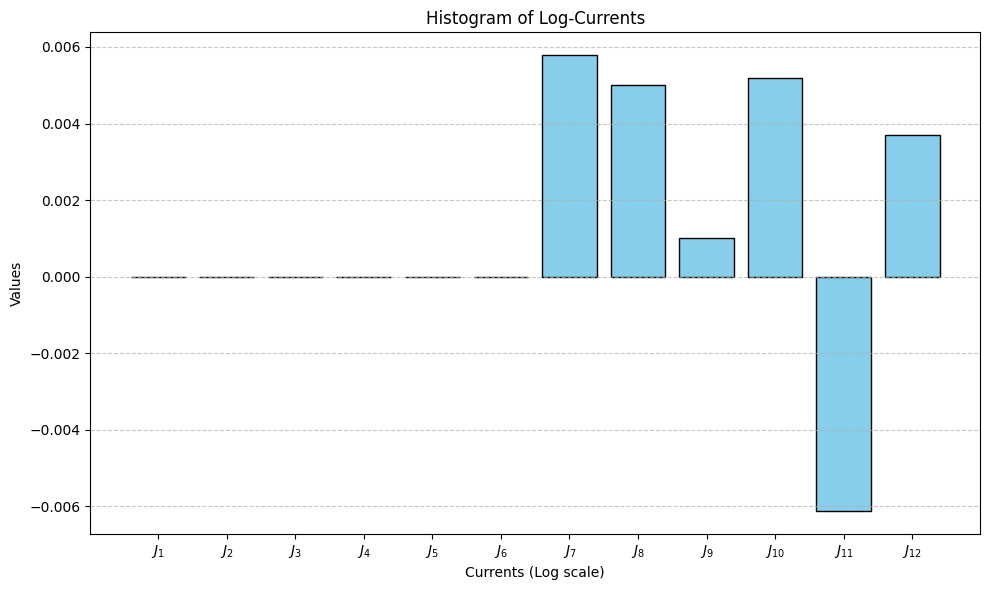

#Species:  15 # Reactions:  30
#Species:  15 # Reactions:  30
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_14', 'C_15']
	 Reactions in AC:  ['R25', 'R28']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R25: C_15 ->2C_14
			 R28: C_14 ->C_15
	 - CPU Time: 0.01 secs
**** Sol 2: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_14', 'C_15']
	 Reactions in AC:  ['R25', 'R30']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R25: C_15 ->2C_14
			 R30: C_14 ->C_15
	 - CPU Time: 0.00 secs
**** Sol 3: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Producti

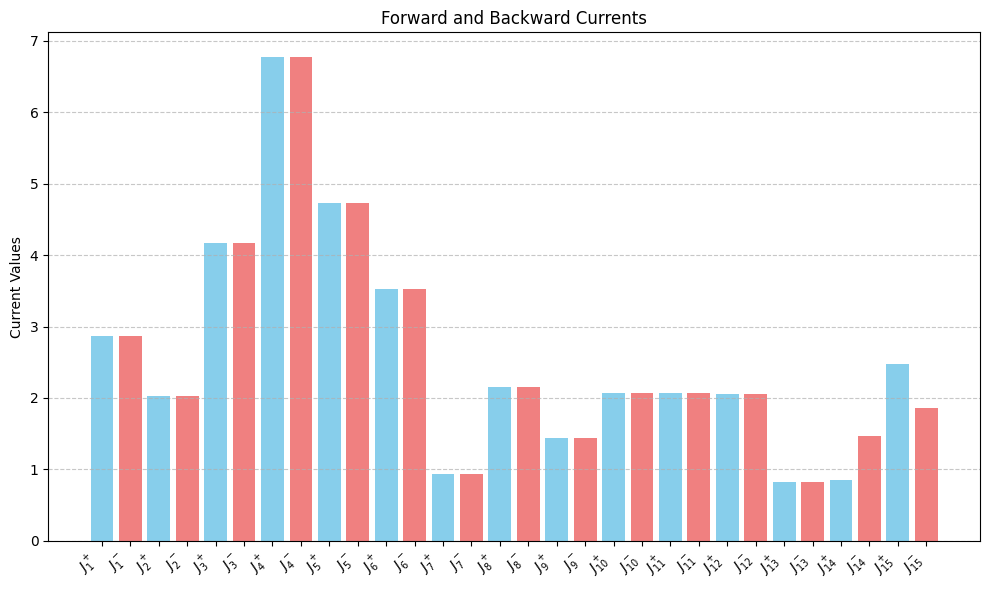

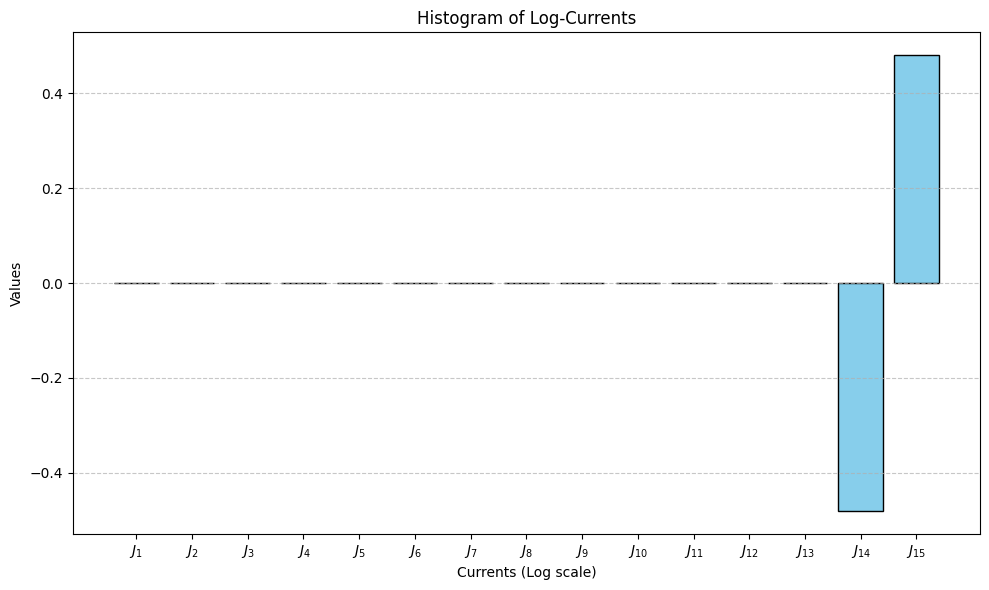

#Species:  18 # Reactions:  36
#Species:  18 # Reactions:  36
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_14', 'C_15']
	 Reactions in AC:  ['R25', 'R28']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R25: C_15 ->2C_14
			 R28: C_14 ->C_15
	 - CPU Time: 0.01 secs
**** Sol 2: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_14', 'C_15']
	 Reactions in AC:  ['R25', 'R30']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R25: C_15 ->2C_14
			 R30: C_14 ->C_15
	 - CPU Time: 0.01 secs
**** Sol 3: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Producti

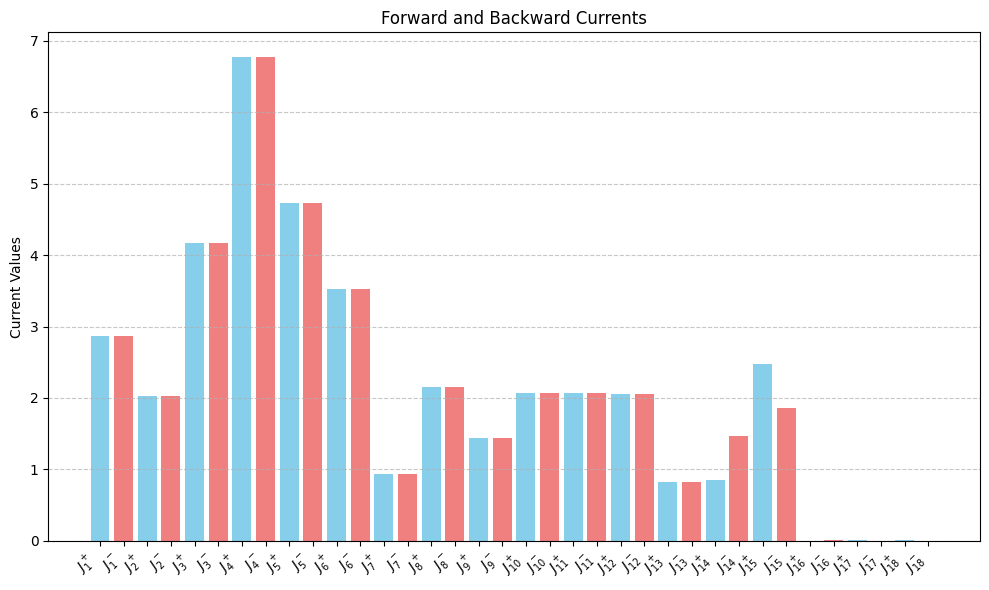

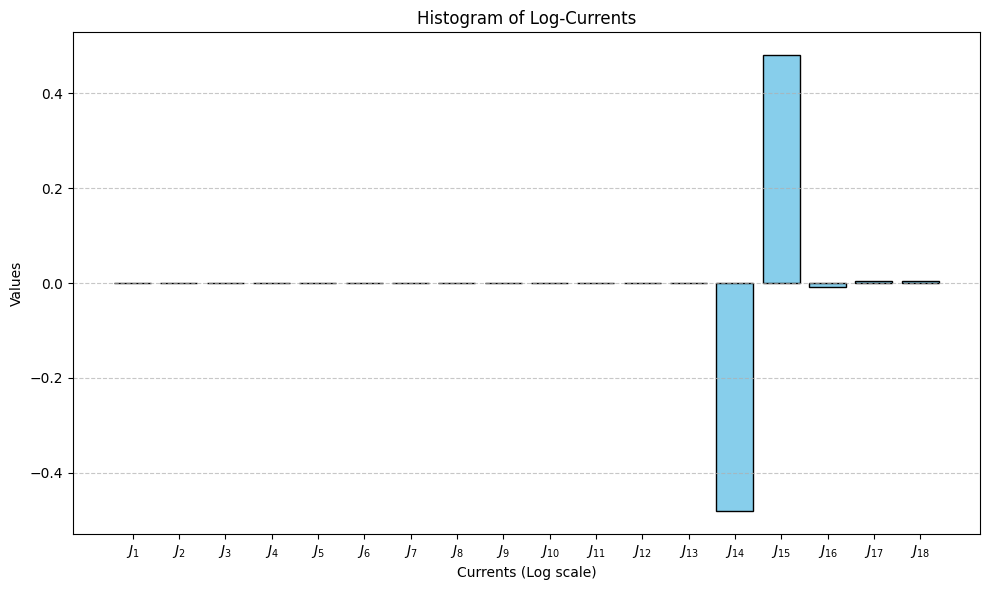

#Species:  18 # Reactions:  36
#Species:  18 # Reactions:  36
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_14', 'C_15']
	 Reactions in AC:  ['R25', 'R28']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R25: C_15 ->2C_14
			 R28: C_14 ->C_15
	 - CPU Time: 0.00 secs
**** Sol 2: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_14', 'C_15']
	 Reactions in AC:  ['R25', 'R30']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R25: C_15 ->2C_14
			 R30: C_14 ->C_15
	 - CPU Time: 0.01 secs
**** Sol 3: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Producti

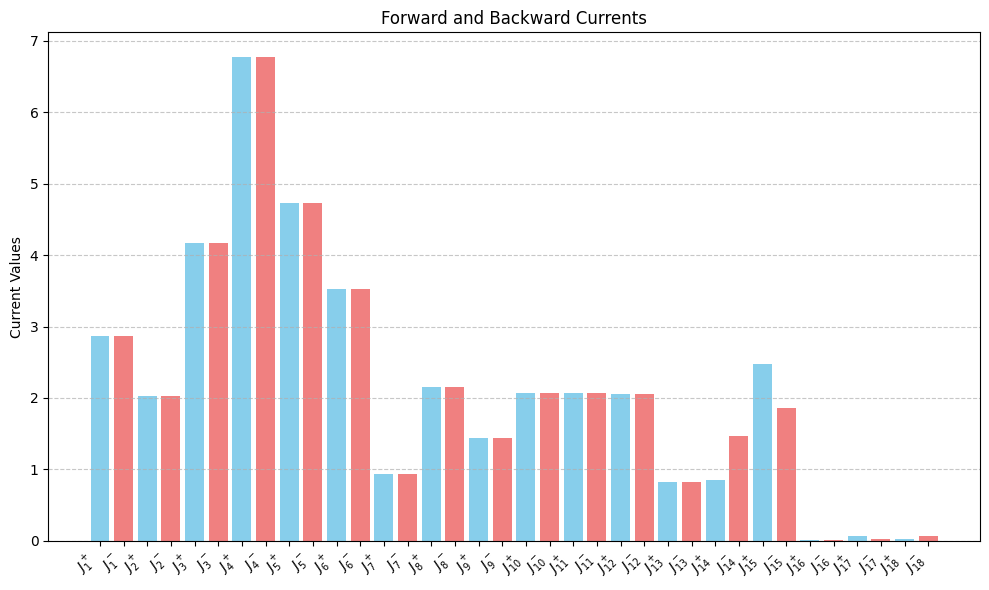

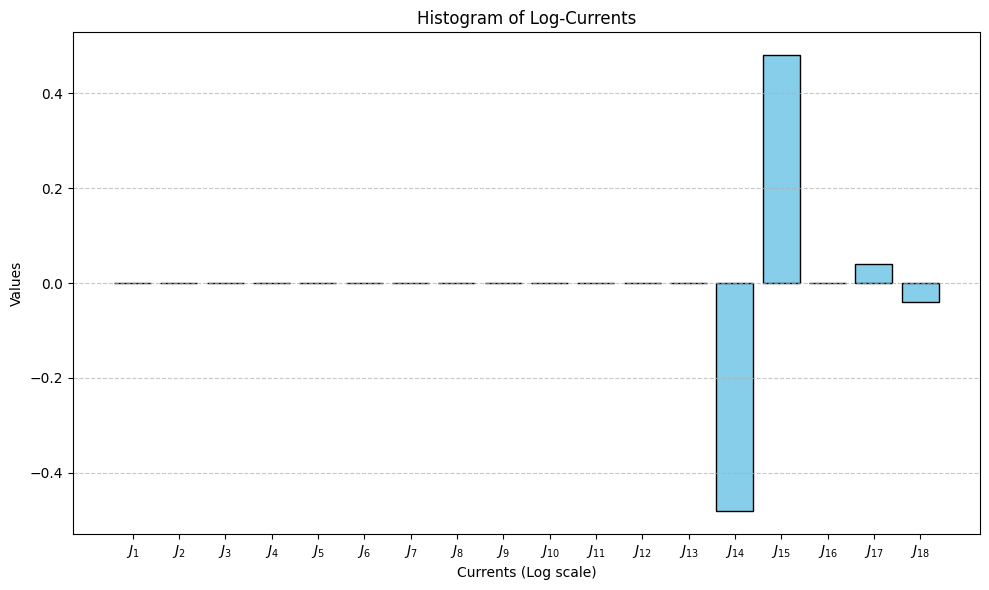

#Species:  18 # Reactions:  36
#Species:  18 # Reactions:  36
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_14', 'C_15']
	 Reactions in AC:  ['R25', 'R30']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R25: C_15 ->2C_14
			 R30: C_14 ->C_15
	 - CPU Time: 0.01 secs
**** Sol 2: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C']
	 Extra M in AC:  []
	 Species in AC:  ['C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_3 ->C+C_2
			 R6: C_2 ->2C_3
	 - CPU Time: 0.01 secs
**** Sol 3: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_14', 'C_15']
	 Reactions in AC:  ['R25', 'R28']
	 Flow:  [] --> Production: 

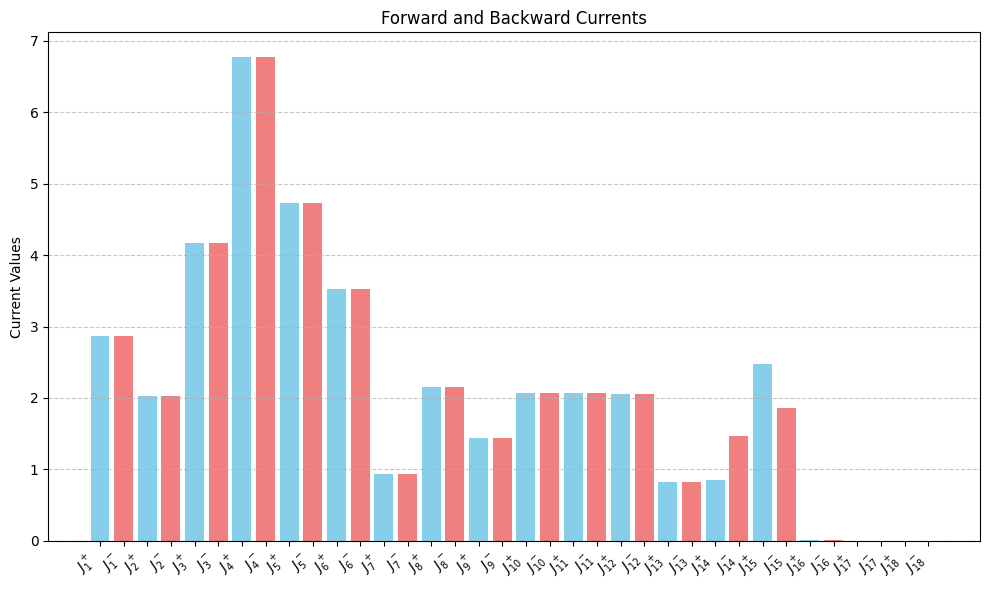

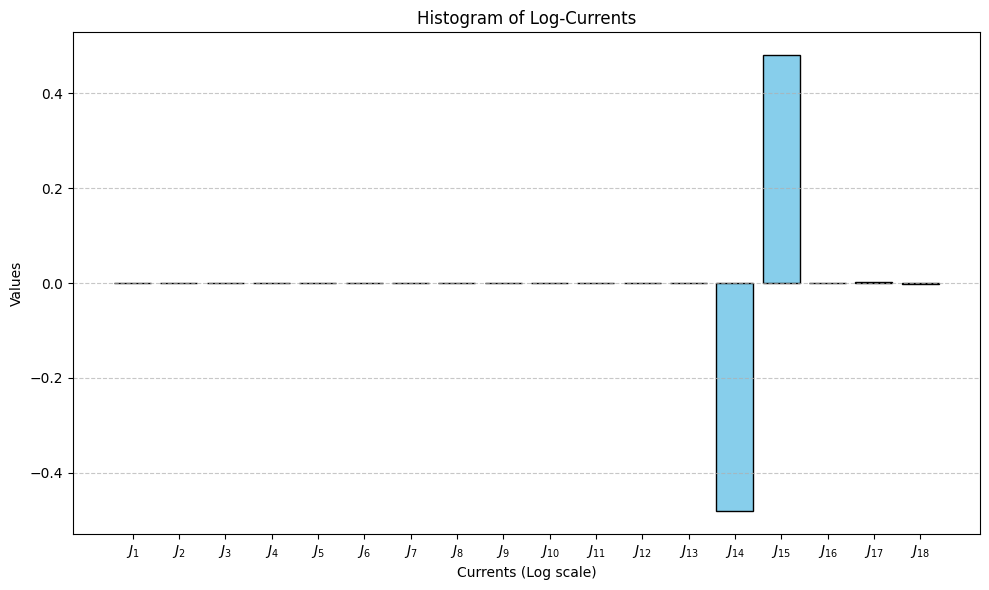

5/10 Realizations led to successful invasion


In [29]:
# Running the code

#law can either be "MAL" or "MM", invaders_autocatalysis is the option of having competition or parasites invaders.

currents, affinities, winning_currents, winning_affinities, number_of_cores = invasion_thermo(N_F, N_Y, N_RY, ttot, dt, Invasions, law = "MAL", invaders_autocatalysis = True)

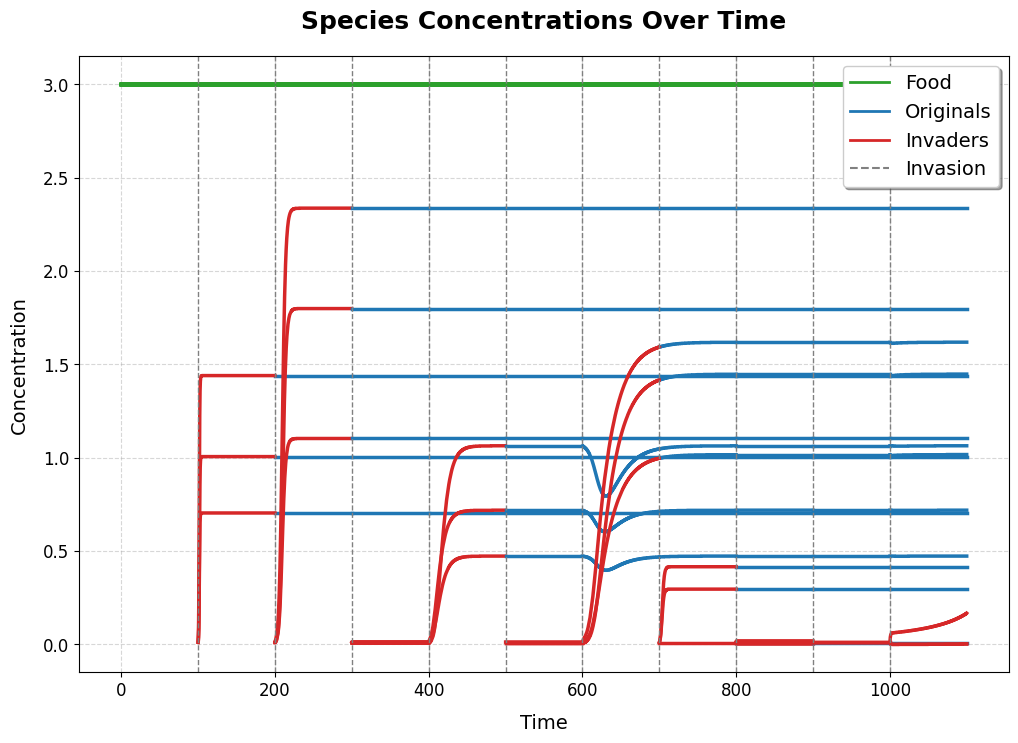

In [30]:
# CELL FOR THE FIRST PLOT


# Set the folder path
folder_path = "output"
file_list = glob.glob(os.path.join(folder_path, "time_*"))

# Create values for the invasions on the x-axis
ttot_values = np.linspace(ttot, ttot * Invasions, Invasions) 

# Figure size and grid
plt.figure(figsize=(12, 8))
plt.grid(True, linestyle='--', alpha=0.5)

# Loop through the files to plot the species
for file in file_list:
    data = pd.read_csv(file, delimiter='\s+', header=None)
    time = data.iloc[:, 0]
    species_data = data.iloc[:, 1:]
    
    # Loop through each species column
    for species_idx in range(species_data.shape[1]):
        if species_idx < N_F:  # First N_X columns in green
            color = '#2ca02c'
        elif species_idx >= species_data.shape[1] - N_Y:  # Last N_Y columns in red
            color = '#d62728'
        else:  # Remaining columns in blue
            color = '#1f77b4'
        
        # Plot each species concentration over time
        plt.plot(time, species_data.iloc[:, species_idx], color=color, linewidth=2.5, alpha=1)

# Vertical lines for invasions
for ttots in ttot_values:
    plt.axvline(x=ttots, color='gray', linestyle='--', linewidth=1, alpha=1)

# Title and axis labels
plt.title('Species Concentrations Over Time', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14, labelpad=10)
plt.ylabel('Concentration', fontsize=14, labelpad=10)

# Customize axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(0,30)
#plt.xlim(700,1000)

# Legend for species categories and invasion
legend_elements = [
    Line2D([0], [0], color='#2ca02c', lw=2, label='Food'),
    Line2D([0], [0], color='#1f77b4', lw=2, label='Originals'),
    Line2D([0], [0], color='#d62728', lw=2, label='Invaders'),
    Line2D([0], [0], color='gray', lw=1.5, linestyle='--', label='Invasion')
]
plt.legend(handles=legend_elements, fontsize=14, frameon=True, shadow=True, loc='upper right')

# Save and display the plot
plt.savefig("images/Successive_species_concentrations.pdf", dpi=300, bbox_inches='tight')
plt.show()



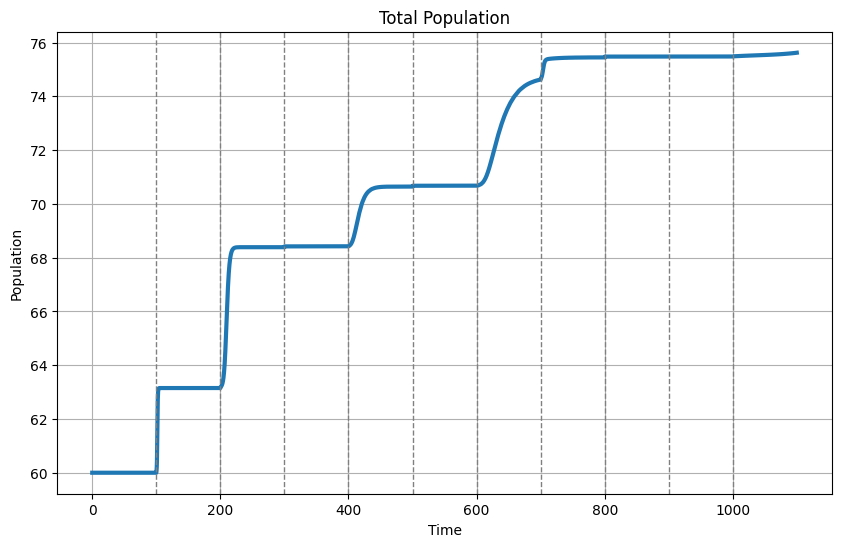

In [31]:
# CELL FOR THE SECOND PLOT


file_path = 'output/Population.dat'

data = pd.read_csv(file_path, delimiter='\s+', header=None)

time = data.iloc[:, 0]
values = data.iloc[:, 1]

ttot_values = np.linspace(ttot, ttot*(Invasions), Invasions) 

plt.figure(figsize=(10, 6))
plt.plot(time, values, label='Total Population', color='#1f77b4', linewidth = 3)

for ttots in ttot_values:
    plt.axvline(x=ttots, color='gray', linestyle='--', linewidth = 1)

plt.xlabel('Time') 
plt.ylabel('Population')  
plt.title('Total Population') 
#plt.legend()  
plt.grid(True)  
plt.savefig('images/Invasions_total.pdf')
plt.show()  


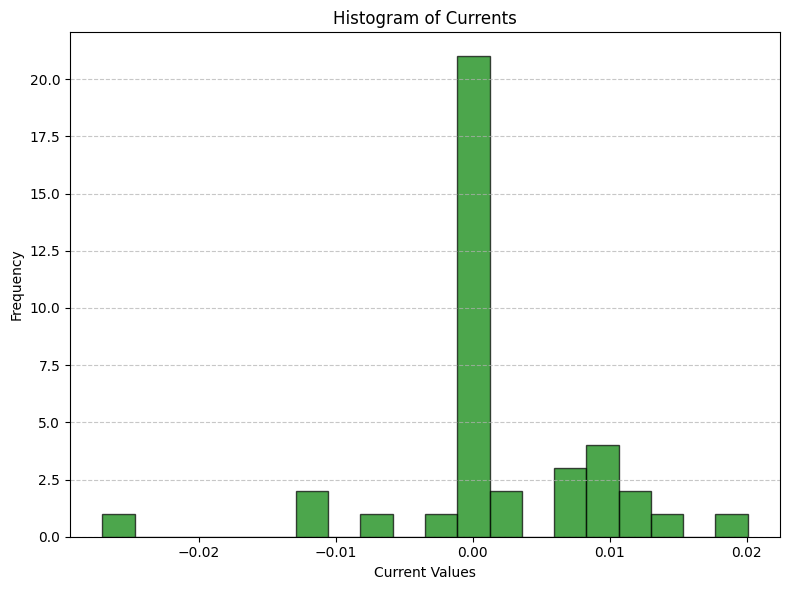

[0.006866340379479752, -0.027046406375229815, 0.013542231743624455, 0.0001234540691571473, -0.00013175055086567244, -3.762553670294544e-06, 0.011758522995847676, 0.008910783864514937, -0.0027451866785646595, -0.00024332159452100655, -0.0001243227859732965, 0.00012055061929516775, 0.00633172158689721, -0.006284380280176638, -0.00011775065960772935, -6.359357485052897e-13, -2.375877272697835e-13, 5.093703236980218e-13, 4.4231285301066237e-13, 5.808686864838819e-13, -4.700684286262913e-13, 8.534921701919274e-05, 8.084545121178621e-05, 0.00011073243029291469, -2.2093438190040615e-13, -1.6564527527407336e-13, 5.5067062021407764e-14, 0.011504028107677089, 0.0008979228208492174, -0.010772886027748951, 0.020071717391783483, 0.010237805609583317, 0.010148437531650734, 0.009519232036955705, -0.011006138351264294, 0.0060856274600276095, 0.001994414821768098, 0.0022894834491211657, -0.0009063113919054455]


In [155]:
# Histogram for currents

bins = 20  # Number of intervals
plt.figure(figsize=(8, 6))
plt.hist(winning_currents, bins=bins, color='green', edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel('Current Values')
plt.ylabel('Frequency')
plt.title('Histogram of Currents')

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('images/Currents_auto.pdf')
plt.show()


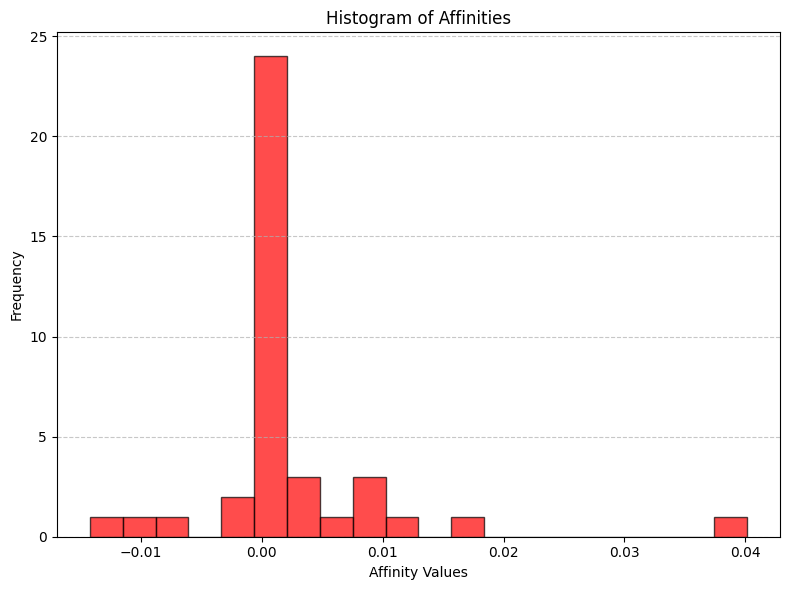

[0.0005107850213083288, -0.006117868366501275, 0.0026599429943495656, 0.00015078074902492064, -0.00013752995043279687, -1.373337072192918e-05, 0.015894220574669857, 0.009505761844214639, -0.00950576184421473, -0.0001823269764158266, -0.00016723112504078293, 9.231210632325262e-05, 0.002091517440660098, -0.002065284101227787, -9.920288691585284e-05, -2.8888003100750743e-13, -2.2715163083833283e-13, 2.2715163083828123e-13, 1.9495516312415848e-13, 1.5187850976870988e-13, -2.369215934550365e-13, 1.629596536916178e-05, 3.9210980418439466e-05, 0.0001790579681407929, -1.4355183708404304e-13, -1.3455903058457804e-13, 1.1102230246251504e-14, 0.0401518558234441, 0.00042956096408868784, -0.01423243573492333, 0.009816337258959897, 0.012239588338715891, 0.00927360505146505, 0.0067365288870169715, -0.00324273912788155, 0.0028845818836512067, 0.001907590429489977, 0.0014530339068013634, -0.0005492623699874227]


In [156]:
# Histogram for affinities
bins = 20  # Numero di intervalli
plt.figure(figsize=(8, 6))
plt.hist(winning_affinities, bins=bins, color='red', edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel('Affinity Values')
plt.ylabel('Frequency')
plt.title('Histogram of Affinities')

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('images/Affinities_auto.pdf')
plt.show()

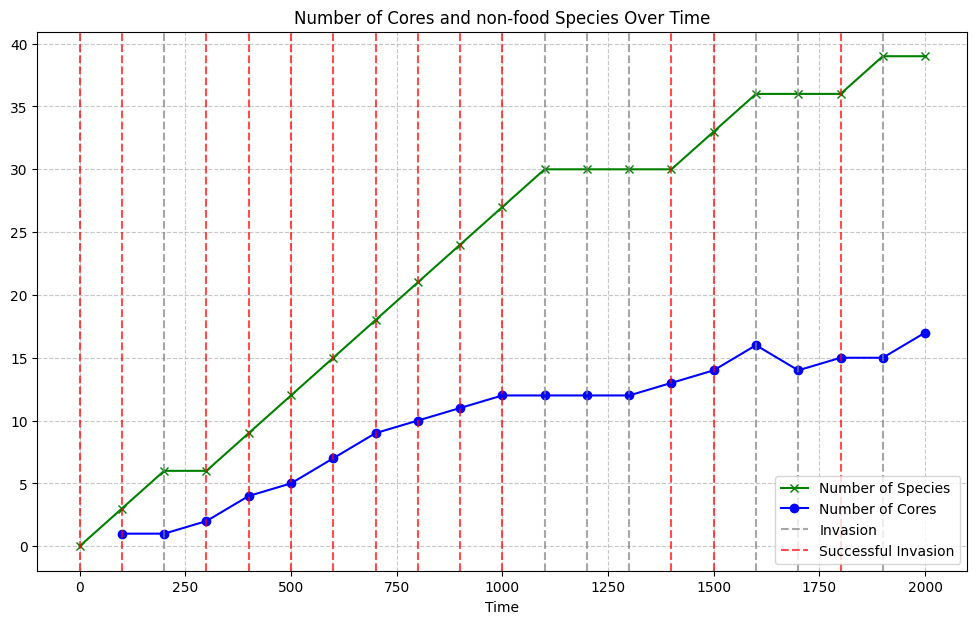

In [158]:
files = [f"output/time_{i}.dat" for i in range(Invasions + 1)]

species_counts = []

for file in files:
    try:
        data = np.loadtxt(file) 
        if data.size == 0:
            print(f"Empty file {file}")
            species_counts.append(0)
            continue

        # Counts the number of column -1 (excluding the time column)
        num_species = data.shape[1] - 1 - N_F
        species_counts.append(num_species)
    except FileNotFoundError:
        print(f"{file} doesn't exist")
        species_counts.append(0)
    except Exception as e:
        print(f"Cannot read {file}: {e}")
        species_counts.append(0)

# 2 different times for the 2 plots
times_species = np.arange(0, len(species_counts) * ttot, ttot)  # From time_0 to time_Invasions
times_cores = np.arange(ttot, (len(number_of_cores) + 1) * ttot, ttot)  # From time_1 to time_Invasions

# Identify invasions as an increase in the number of species
increase_times = []
increase_special_times = []
previous_species_count = species_counts[0]

for i in range(1, len(species_counts)):
    current_species_count = species_counts[i]
    if current_species_count > previous_species_count:
        increase_special_times.append(times_species[i-1])
    else:
        increase_times.append(times_species[i-1])
    previous_species_count = current_species_count

plt.figure(figsize=(12, 7))

# Plot for the number of species
plt.plot(times_species, species_counts, label="Number of Species", marker='x', color='green')

# Plot for the number of cores
plt.plot(times_cores, number_of_cores, label="Number of Cores", marker='o', color='blue')

# Vertical lines for invasions
for t in increase_times:
    plt.axvline(x=t, color='gray', linestyle='--', alpha=0.7, label='Invasion' if t == increase_times[0] else "")

# Red vertical lines for successful
for t in increase_special_times:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, label='Successful Invasion' if t == increase_special_times[0] else "")

# Plot configuration
plt.xlabel("Time")
#plt.ylabel("Count")
plt.title("Number of Cores and non-food Species Over Time")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('images/Cores_species_auto.pdf')
plt.show()
